<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/Bama_test_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [335]:
!wget --no-check-certificate \
    https://github.com/omidmno2/stockMarketPrediction_DL/raw/main/tse_en.csv \
    -o /tmp/tse_en.csv

In [336]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [337]:
df = pd.read_csv("tse_en.csv")
df[df.Symbol == "كاما"]

,Date,Symbol,Name,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
1,2008-12-06,كاما,باما,2580,2657,2657,2605,25,2656.0,2657.0,14,21000,55793000
91,2008-12-07,كاما,باما,2605,2683,2565,2641,36,2565.0,2683.0,18,35139,93799687
271,2008-12-08,كاما,باما,2641,2571,2591,2596,-45,2569.0,2621.0,25,42835,110269609
356,2008-12-10,كاما,باما,2596,2571,2565,2586,-10,2519.0,2571.0,7,10557,26763973
467,2008-12-13,كاما,باما,2586,2509,2557,2573,-13,2509.0,2557.0,8,20845,53055381
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817313,2021-06-22,كاما,باما,8360,8350,8590,8570,210,8330.0,8730.0,3411,25348235,217287363260
817707,2021-06-23,كاما,باما,8570,8630,8930,8870,300,8460.0,8990.0,5526,56882857,504425474870
818107,2021-06-26,كاما,باما,8870,9000,9130,9240,370,8950.0,9310.0,8390,76418737,706464851400
818801,2021-06-27,كاما,باما,9240,9140,8860,9010,-230,8780.0,9240.0,7841,51136692,460489973080


In [338]:
bama = df[df.Symbol == "كاما"]
bama.index = pd.to_datetime(bama['Date'])
bama = bama.drop(columns=['Symbol', 'Name', 'Date']).dropna()
bama = bama.head(2400)

In [339]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

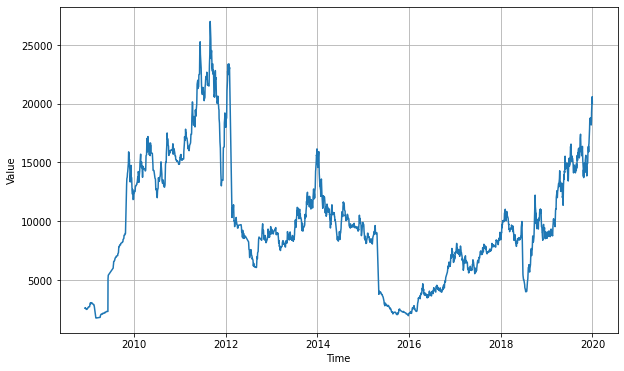

In [340]:
# Normal data

series = np.array(bama.Close)
time = np.array(bama.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

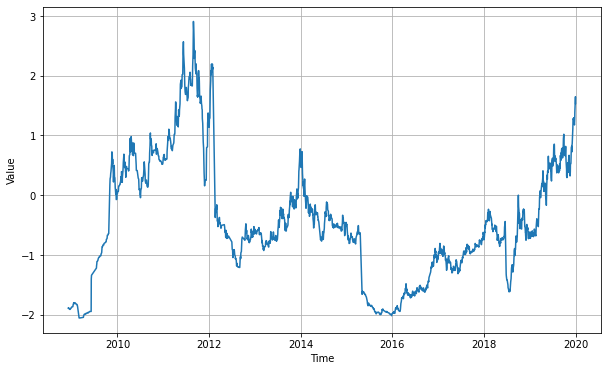

In [341]:
# Standardized Data

series = bama['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(bama.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [342]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [343]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [344]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [345]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)
Epoch 1/100
8/8 [==============================] - 4s 42ms/step - loss: 3.7148 - mae: 4.1879
Epoch 2/100
8/8 [==============================] - 1s 52ms/step - loss: 3.6075 - mae: 4.0815
Epoch 3/100
8/8 [==============================] - 1s 56ms/step - loss: 3.4391 - mae: 3.9143
Epoch 4/100
8/8 [==============================] - 1s 54ms/step - loss: 3.2372 - mae: 3.7133
Epoch 5/100
8/8 [==============================] - 1s 52ms/step - loss: 3.0115 - mae: 3.4886
Epoch 6/100
8/8 [==============================] - 1s 51ms/step - loss: 2.7684 - mae: 3.2461
Epoch 7/100
8/8 [==============================] - 1s 53ms/step - loss: 2.5140 - mae: 2.9918
Epoch 8/100
8/8 [==============================] - 1s 54ms/step - loss: 2.2497 - mae: 2.7264
Epoch 9/100
8/8 [==============================] - 1s 55ms/step - loss: 1.9787 - mae: 2.4534
Epoch 10/100
8/8 [==============================] - 1s 54ms/s

(1e-08, 0.0001, 0.0, 2.0)

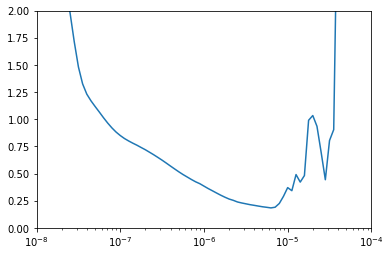

In [347]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 2])

In [348]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
20/20 [==============================] - 5s 35ms/step - loss: 0.9072 - mae: 1.3093
Epoch 2/150
20/20 [==============================] - 1s 35ms/step - loss: 0.2557 - mae: 0.5868
Epoch 3/150
20/20 [==============================] - 1s 37ms/step - loss: 0.1577 - mae: 0.4405
Epoch 4/150
20/20 [==============================] - 1s 37ms/step - loss: 0.0765 - mae: 0.2841
Epoch 5/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0688 - mae: 0.2672
Epoch 6/150
20/20 [==============================] - 1s 37ms/step - loss: 0.0620 - mae: 0.2480
Epoch 7/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0594 - mae: 0.2408
Epoch 8/150
20/20 [==============================] - 1s 37ms/step - loss: 0.0563 - mae: 0.2325
Epoch 9/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0551 - mae: 0.2298
Epoch 10/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0534 - mae: 0.2250
Epoch 11/150
20/20 [=============================

In [349]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

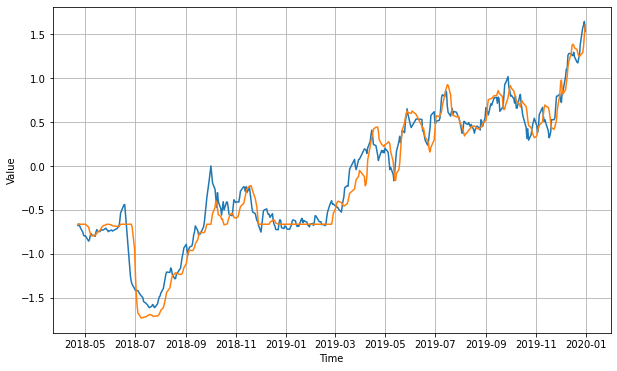

In [350]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [351]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.11736987

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS